In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard

In [2]:
%matplotlib inline
sns.set(style='whitegrid')

In [3]:
df = pd.read_csv("C:\\Users\\Shubham Dhamal\\Downloads\\creditcard.csv")

In [4]:
df = df.drop(['Time'], axis=1)

In [5]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

In [6]:
df_fraud = df[df['Class']==1]
df_normal = df[df['Class']==0]
df_normal = df_normal.sample(frac = 1.0).reset_index(drop = True) #Just shuffling
df_normal_1 = df_normal.iloc[:int(df_normal.shape[0]*0.8),:] #80% of normal data for training
df_normal_2 = df_normal.iloc[int(df_normal.shape[0]*0.8):,:] #20% of normal data to merge with fraudulent (test set)

In [7]:
X_test = pd.concat([df_fraud,df_normal_2], axis = 0)
X_test = X_test.sample(frac = 1.0).reset_index(drop = True) #Just shuffling
 
#Separate in input and target variables
X_train = df_normal_1[df_normal_1['Class'] == 0]
X_train = X_train.drop(['Class'], axis=1)
 
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

In [8]:
#Build the Neural Network
input_dim = X_train.shape[1]
encoding_dim = 14
 
model = Sequential()
model.add(Dense(29,input_dim = input_dim, activation="relu"))
model.add(Dense(14, activation="relu"))
model.add(Dense(7, activation="relu"))
model.add(Dense(14, activation="relu"))
model.add(Dense(input_dim, activation="sigmoid"))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 29)                870       
                                                                 
 dense_1 (Dense)             (None, 14)                420       
                                                                 
 dense_2 (Dense)             (None, 7)                 105       
                                                                 
 dense_3 (Dense)             (None, 14)                112       
                                                                 
 dense_4 (Dense)             (None, 29)                435       
                                                                 
Total params: 1,942
Trainable params: 1,942
Non-trainable params: 0
_________________________________________________________________


In [10]:
#Fit the autoencoder and check loss for train and test
checkpointer = ModelCheckpoint(filepath="nae.h5", verbose=0, save_best_only=True)

In [12]:
#Save history to plot learning curves
history = model.fit(X_train, X_train,
epochs=10,
batch_size=32,
shuffle=True,
validation_data=(X_test, X_test),
verbose=1,
callbacks=[checkpointer]).history
 
autoencoder = load_model('nae.h5')
 

Epoch 1/10
7108/7108 [==============================] - 19s 3ms/step - loss: 0.7972 - accuracy: 0.5453 - val_loss: 1.0643 - val_accuracy: 0.5394
Epoch 2/10
7108/7108 [==============================] - 18s 3ms/step - loss: 0.7960 - accuracy: 0.5445 - val_loss: 1.0648 - val_accuracy: 0.5502
Epoch 3/10
7108/7108 [==============================] - 28s 4ms/step - loss: 0.7950 - accuracy: 0.5430 - val_loss: 1.0667 - val_accuracy: 0.5492
Epoch 4/10
7108/7108 [==============================] - 18s 3ms/step - loss: 0.7939 - accuracy: 0.5437 - val_loss: 1.0611 - val_accuracy: 0.5425
Epoch 5/10
7108/7108 [==============================] - 23s 3ms/step - loss: 0.7933 - accuracy: 0.5484 - val_loss: 1.0608 - val_accuracy: 0.5451
Epoch 6/10
7108/7108 [==============================] - 18s 2ms/step - loss: 0.7927 - accuracy: 0.5502 - val_loss: 1.0594 - val_accuracy: 0.5561
Epoch 7/10
7108/7108 [==============================] - 29s 4ms/step - loss: 0.7922 - accuracy: 0.5521 - val_loss: 1.0605 - val_ac

Text(0.5, 0, 'epoch')

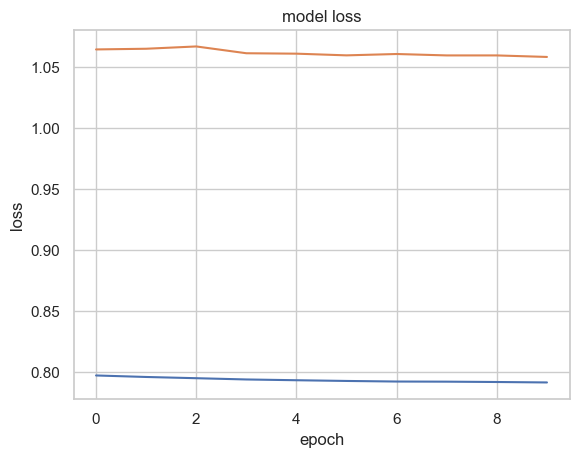

In [13]:
#Plot losses
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [14]:
#Predict on test set
predictions = model.predict(X_test)
 
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'mse': mse,'fraud': y_test})

1793/1793 [==============================] - 4s 2ms/step


In [15]:
#Set an error threshold above which a transaction is considered fraud
threshold = 4.5
error_df['pred_01'] = [1 if e > threshold else 0 for e in error_df['mse'].values]
conf_mat = confusion_matrix(error_df['fraud'], error_df['pred_01'])

[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Fraud')]

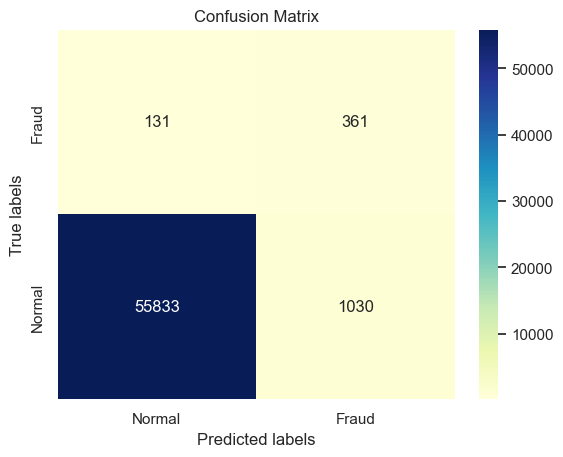

In [16]:
#Print confusion matrix for the given threshold
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, fmt="g", cmap="YlGnBu")
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.set_ylim([0,2])
ax.xaxis.set_ticklabels(["Normal", "Fraud"]); ax.yaxis.set_ticklabels(["Normal", "Fraud"])